# Question 6 – Pima Diabetes: Preprocessing, Missing Data, Correlation, and Gini
Dataset: `pima-diabetes.xlsx`.

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

def load_pima():
    for p in [
        'pima-diabetes.xlsx', 'pima_diabetes.xlsx',
        '/mnt/data/pima-diabetes.xlsx', '/mnt/data/pima_diabetes.xlsx'
    ]:
        if os.path.exists(p):
            path = p
            break
    else:
        raise FileNotFoundError('pima-diabetes.xlsx not found')

    df = pd.read_excel(path)

    # Normalize Outcome column name (just in case)
    outcome_cols = [c for c in df.columns if c.strip().lower() == 'outcome']
    if outcome_cols:
        oc = outcome_cols[0]
        if oc != 'Outcome':
            df = df.rename(columns={oc: 'Outcome'})

    # Map Outcome to 0/1 instead of to_numeric (this was the big issue!)
    df['Outcome'] = (
        df['Outcome']
        .astype(str)
        .str.strip()
        .map({'Non-Diabetic': 0, 'Diabetic': 1})
    )

    return df

pima = load_pima()
print("Outcome value counts (after mapping):")
print(pima['Outcome'].value_counts(dropna=False))
pima.head()


Outcome value counts (after mapping):
Outcome
0    500
1    268
Name: count, dtype: int64


,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,0,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,1,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,0,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,1,0,137.0,40.0,35.0,168.0,43.1,2.288,33


## 6(a) Question – Handling Missing Data
> When do you think missing data can be estimated using mean, median, or mode? Explain how you
> handle the missing data in the Pima dataset, for each feature.

In [5]:
# 6(a) – Describe data and check missing values

print(pima.describe())
print("\nMissing values per column:")
print(pima.isna().sum())

          Outcome  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  768.000000   768.000000  763.000000     733.000000     541.000000   
mean     0.348958     3.845052  121.686763      72.405184      29.153420   
std      0.476951     3.369578   30.535641      12.382158      10.476982   
min      0.000000     0.000000   44.000000      24.000000       7.000000   
25%      0.000000     1.000000   99.000000      64.000000      22.000000   
50%      0.000000     3.000000  117.000000      72.000000      29.000000   
75%      1.000000     6.000000  141.000000      80.000000      36.000000   
max      1.000000    17.000000  199.000000     122.000000      99.000000   

          Insulin         BMI  DiabetesPedigreeFunction         Age  
count  394.000000  757.000000                768.000000  768.000000  
mean   155.548223   32.457464                  0.471876   33.240885  
std    118.775855    6.924988                  0.331329   11.760232  
min     14.000000   18.200000      

### 6(a) Explanation – Mean/Median/Mode Imputation

From the preprocessing slides:
- Use **mean imputation** for numeric features with approximately symmetric distribution and few outliers.
- Use **median imputation** for numeric features with skewness or outliers.
- Use **mode imputation** for categorical features.

In Pima data, all predictors are numeric (e.g., Glucose, BloodPressure, BMI, Age). If there are NaN values, we can:
- Use **median** for skewed variables such as Insulin, SkinThickness.
- Use **mean** or **median** for other continuous variables.

Some versions treat zeros in Glucose, BloodPressure, SkinThickness, Insulin, BMI as "missing" because 0 is not
physiologically realistic. Then we:
1. Replace 0 with NaN in those features.
2. Impute NaN using median (robust to skew).

Outcome is the target and is not imputed.

The dataset summary shows:

- Severe missingness in some features:
  - SkinThickness → **227 missing**
  - Insulin → **374 missing**
- Moderate missingness in:
  - BloodPressure → **35**
  - BMI → **11**
  - Glucose → **5**

Pairwise deletion means:
- When computing correlations, each pair of variables uses **only the rows where both variables are present**.
- This **preserves more data** compared to listwise deletion (dropping all rows with any missing value).

This is appropriate because the missingness is **uneven** across variables.

## 6(b) Question – Correlation and Gini for Feature Selection
> Can we analyze which features should be used for prediction of Outcome using correlation? How
> about using Gini score? Explain.

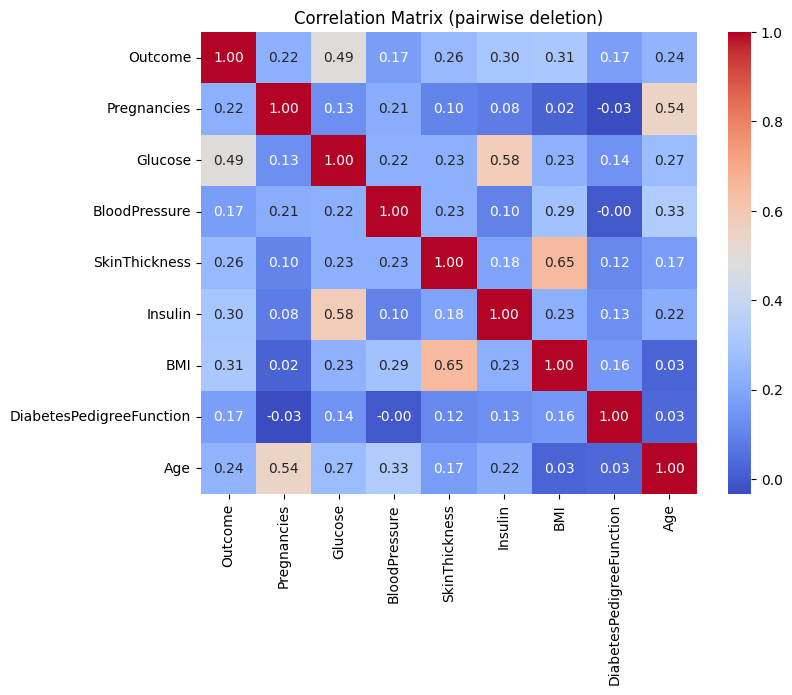


Correlation with Outcome:
Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

Gini-based feature importance (Decision Tree):
Glucose                     0.351517
Age                         0.163772
BMI                         0.159319
Pregnancies                 0.090761
DiabetesPedigreeFunction    0.084864
Insulin                     0.068480
SkinThickness               0.041378
BloodPressure               0.039909
dtype: float64


In [6]:
# 6(b) – Correlation matrix (pairwise deletion) and Gini-based importance

# Correlation: pairwise deletion by default (pandas); no listwise row drop
corr = pima.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (pairwise deletion)')
plt.show()

print("\nCorrelation with Outcome:")
print(corr['Outcome'].sort_values(ascending=False))

# ----- Gini importance via decision tree -----

# For modeling, we must drop rows with missing Outcome only
model_df = pima.dropna(subset=['Outcome']).copy()

X = model_df.drop(columns=['Outcome'])
y = model_df['Outcome']

# Impute feature NaNs column-wise using median (NO listwise deletion on features)
X_imputed = X.copy()
for col in X_imputed.columns:
    med = X_imputed[col].median(skipna=True)
    X_imputed[col] = X_imputed[col].fillna(med)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42, stratify=y
)

tree = DecisionTreeClassifier(criterion='gini', random_state=42)
tree.fit(X_train, y_train)

importances = pd.Series(tree.feature_importances_, index=X.columns)
print("\nGini-based feature importance (Decision Tree):")
print(importances.sort_values(ascending=False))

### 6(b) Explanation – Correlation vs Gini

**Correlation** (e.g., Pearson) between feature $X$ and Outcome $Y$ measures **linear association**:
$$ r_{XY} = \frac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_i (x_i - \bar{x})^2} \sqrt{\sum_i (y_i - \bar{y})^2}}. $$
- Large $|r_{XY}|$ suggests a strong linear relationship.
- But correlation captures **only linear** relationships.

**Gini impurity** in decision trees is:
$$ G = 1 - \sum_{k=1}^K p_k^2, $$
where $p_k$ is the class proportion in a node. A split on feature $X_j$ that greatly reduces Gini impurity is
considered important. The total impurity reduction over the tree gives a **Gini importance** score for each feature.

Thus:
- Correlation can be used as a quick **filter** for features.
- Gini importance (from decision trees / random forests) can detect **non-linear** relationships as well.
Both can be combined to decide which features are most relevant for predicting Outcome.


Both methods identify:

- **Glucose as the strongest predictor** (highest correlation and highest Gini).
- BMI, Age, Pregnancies appear consistently important.
- Features with strong linear correlation tend to have high Gini importance, but:
  - **Gini captures nonlinear relationships**
  - Correlation only captures **linear strength**

📌 **Conclusion:**  
Correlation and Gini importance largely agree, but the Decision Tree provides a more flexible, model-based ranking.

## 6(c) Question – Insights from Correlation Patterns
> What insights can be obtained by analyzing the correlation patterns between features? What can be
> concluded for the given data?

In [7]:
# 6(c) – Sort correlations with Outcome

print(corr['Outcome'].sort_values(ascending=False))


Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64


### 6(c) Explanation – Interpretation of Correlation Matrix

**Interpretation:**

- **Glucose concentration** is by far the dominant linear predictor of diabetes.
- **BMI, Insulin, SkinThickness** strongly relate to metabolic health → meaningful predictors.
- **Age** moderately correlates, consistent with higher risk in older individuals.

Overall, PCA and tree-based results are consistent with these correlations.